# Fine-tune `roberta-base` model

In this notebook, we will fine-tune [the `roberta-base` model][1], so that it can represent math-specific tokens.

 [1]: https://huggingface.co/roberta-base

In [1]:
! hostname

mir


In [2]:
%%capture
! pip install .[transformers,evaluation]

In [3]:
%%capture
! make tuned-roberta-base-text+latex

## Intrinsic evaluation

To validate our model during the training, we will plot the validation loss.

### In-domain evaluation

To see how well our model generalizes to unseen data from out target domain (scientific texts), we use a small held-out validation dataset.

In [4]:
%ls -lh dataset-text+latex.txt  # this is the training dataset

-rw-r--r-- 1 novotny novotny 52G May  5 03:52 dataset-text+latex.txt


In [5]:
%ls -lh dataset-text+latex-validation.txt  # this is the validation dataset

-rw-r--r-- 1 novotny novotny 457M May  6 00:11 dataset-text+latex-validation.txt


In [6]:
import json
from pathlib import Path

def get_checkpoint_step(input_checkpoint_directory: Path) -> int:
    _, checkpoint_step = input_checkpoint_directory.name.split('-')
    checkpoint_step = int(checkpoint_step)
    return checkpoint_step

checkpoints = Path('tuned-roberta-base-text+latex.MLM-objective').glob('*/')
latest_checkpoint = max(checkpoints, key=get_checkpoint_step)
with (latest_checkpoint / 'trainer_state.json').open('rt') as f:
    trainer_state = json.load(f)

train_losses = []
validation_losses = []

for log in trainer_state['log_history']:
    epoch = float(log['epoch'])
    if 'loss' in log:
        loss = float(log['loss'])
        train_losses.append((epoch, loss))
    if 'eval_loss' in log:
        eval_loss = float(log['eval_loss'])
        validation_losses.append((epoch, eval_loss))

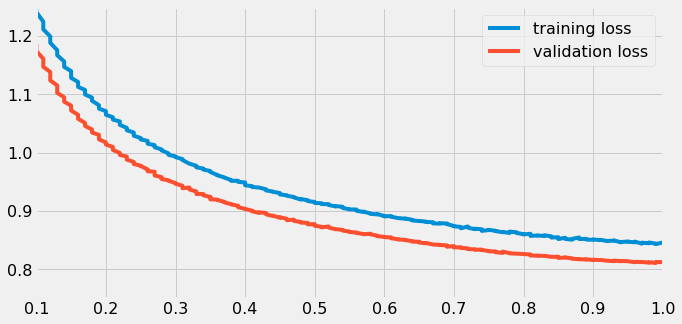

In [7]:
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=16)

plt.figure(figsize=(10, 5)) 
plt.plot(*zip(*train_losses), label='training loss')
plt.plot(*zip(*validation_losses), label='validation loss')
plt.xlim((0.1, epoch))
plt.ylim((0.75, 1.25))
_ = plt.legend()